# Method Validation

## Load packages

In [1]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from scipy.stats import gaussian_kde

from sksurv.datasets import load_gbsg2, load_whas500, load_aids
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

import shap

## General purpose functions

In [4]:
def split_and_train(X, y, model_name, seed=20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    model = get_model(model_name, seed)
    model.fit(X_train, y_train)

    return model, (X_train, y_train), (X_test, y_test)

def get_model(name, seed=20):
  if name == 'rf':
    model = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=seed)
  elif name == 'cox':
    model = CoxPHSurvivalAnalysis()
  else:
    raise ValueError(f"Unrecognised model name '{name}'!")

  return model

def get_feature_importances(model, X_test, y_test, seed=20):
    result = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=seed)

    df = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': result['importances_mean']
    })

    return df

def get_explanations(model, X_test, eps):
    # compute the reference point (average patient)
    X_mean = X_test.mean().to_frame().T

    # find average risk
    y_mean = model.predict(X_mean)
    # predict risk for all
    y_pred = model.predict(X_test)

    # select only those individuals whose change in risk with respect to the reference point is smaller than epsilon (i.e. close to 0)
    sel_mask = np.abs(y_pred - y_mean) < eps

    # use the reference point
    ex = shap.KernelExplainer(model.predict, X_mean)
    explanation = ex(X_test[sel_mask])
    df_shap = pd.DataFrame(explanation.values, columns=X_test.columns)


    sel_data = X_test[sel_mask]

    # get SHAP values of the selected individuals (delta_R close to 0)
    return df_shap, sel_data

def make_plot(df_shap, org_df, filename, plot_type='scatter', xlabel='SHAP value', figsize=(4, 3)):
  features = df_shap.columns.to_list()
  n_feats = len(features)

  fig, ax = plt.subplots(figsize=figsize)

  if plot_type == 'violin':
    if org_df is not None:
      shap_long = df_shap.melt(var_name='Feature', value_name='SHAP Value')
      feat_long = org_df.melt(var_name='Feature', value_name='Feature Value')
      data = pd.concat([shap_long, feat_long['Feature Value']], axis=1)
    else:
      raise ValueError('No original faeture values provided')

    for i, feature in enumerate(features):
      df_feat = data[data['Feature'] == feature]
      try:
        kde = gaussian_kde(df_feat['SHAP Value'].values)
        x_vals = df_feat['SHAP Value'].values
        density_vals = kde(x_vals)

        density_vals = density_vals/density_vals.max()*0.4

        y_center = i
        y_vals = np.random.uniform(low=i-density_vals, high=i+density_vals)
      except np.linalg.LinAlgError:
        print(f'KDE failed for feature {feature}, using scatter fallback')
        x_vals = df_feat['SHAP Value'].values
        y_vals = np.full_like(df_feat['SHAP Value'], fill_value=i, dtype=float)
      val = df_feat['Feature Value'].values
      if (val.max() - val.min()) == 0.0:
        val_norm = np.full_like(val, fill_value=val.max(), dtype=float)
      else:
        val_norm = (val - val.min()) / (val.max() - val.min())

      sc = ax.scatter(
          x_vals, y_vals,
          c=val_norm,
          cmap='coolwarm', edgecolors='None', s=20, alpha=0.8
      )

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Feature Value')
    cbar.set_ticks([])
    cbar.ax.text(1.05, 0.05, 'Low', transform=cbar.ax.transAxes, va='center')
    cbar.ax.text(1.05, 0.95, 'High', transform=cbar.ax.transAxes, va='center')
  elif plot_type == 'bar':
    for i, feature in enumerate(features):
      x = df_shap[feature].values
      y = np.full_like(x, fill_value=i, dtype=float)
      plt.barh(y, x, align='center')

  ax.axvline(0.0, c='k', linewidth=0.5)
  ax.set_yticks(np.arange(n_feats))
  ax.set_yticklabels(features)

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Feature')
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)

  plt.grid(True, axis='both', linestyle='--', alpha=0.5)
  plt.savefig(f'plots/{filename}.pdf', dpi=1000)
  plt.tight_layout()
  plt.show()

## GBSG 2

  0%|          | 0/27 [00:00<?, ?it/s]

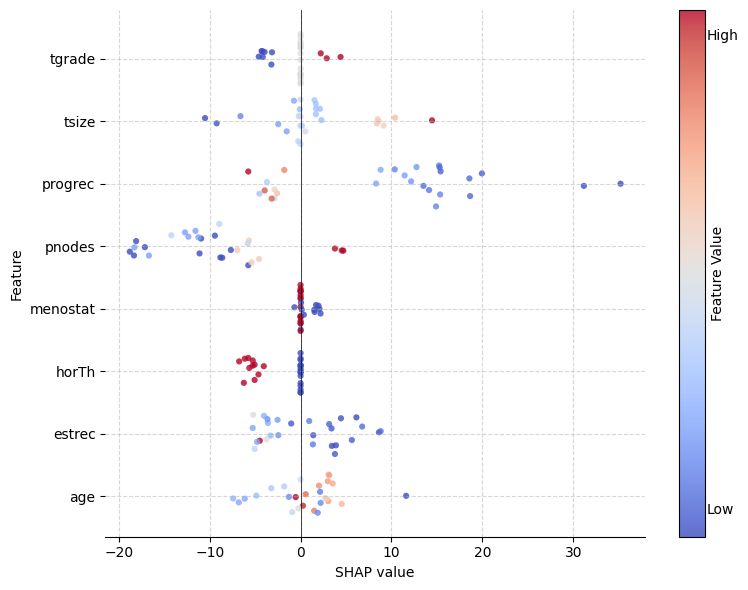

  0%|          | 0/12 [00:00<?, ?it/s]

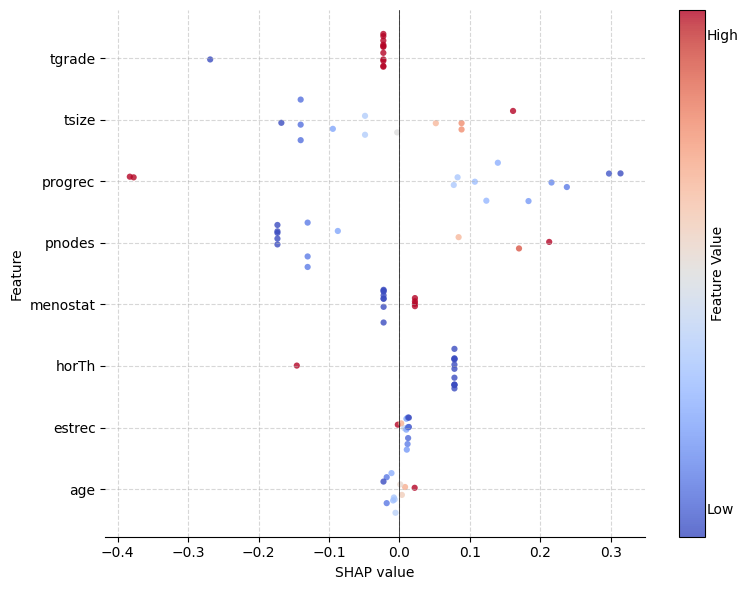

In [26]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

Xt.rename(columns={'horTh=yes': 'horTh', 'menostat=Post': 'menostat'}, inplace=True)

for model_name in ['rf', 'cox']:
  model, (X_train, y_train), (X_test, y_test) = split_and_train(Xt, y, model_name)
  eps = model.predict(X_train).std()/10.0
  ex_result, org_df = get_explanations(model, X_test, eps)
  make_plot(ex_result, org_df, f'gbsg2_{model_name}', 'violin', 'SHAP value', (8, 6))

## AIDS

  0%|          | 0/34 [00:00<?, ?it/s]

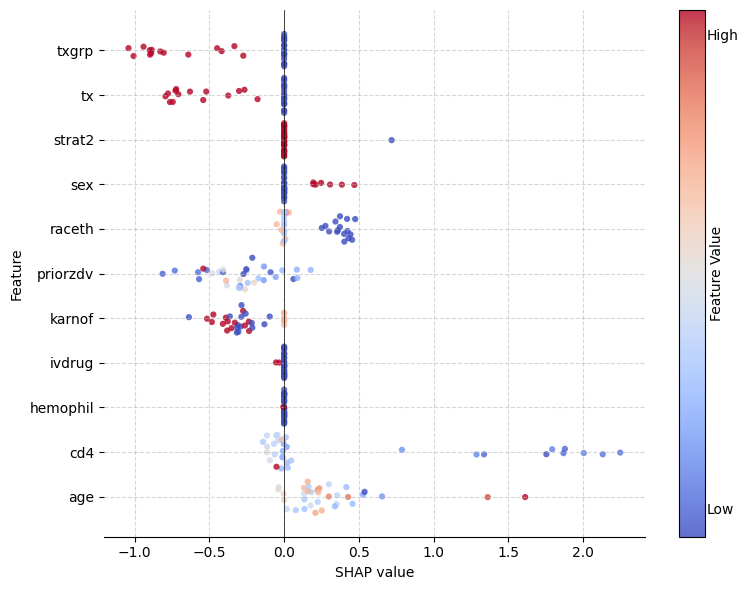

  0%|          | 0/24 [00:00<?, ?it/s]

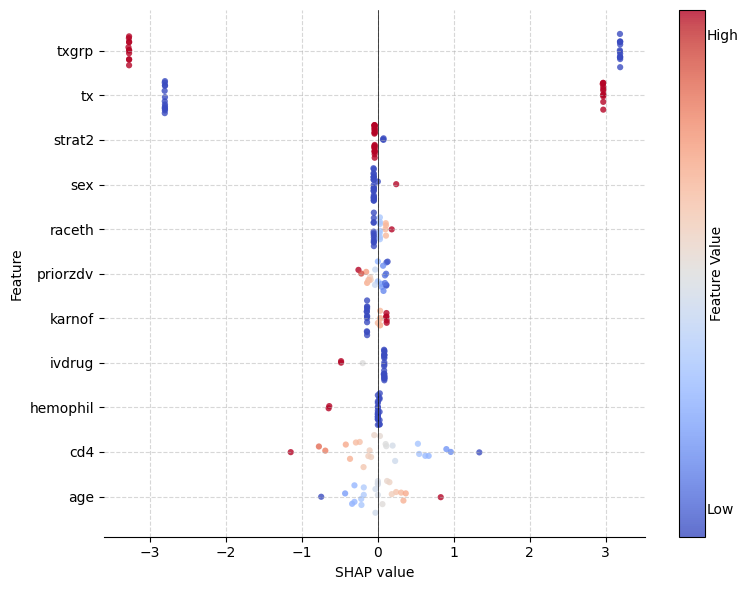

In [28]:
X, y = load_aids()

cat_cols = ['hemophil', 'ivdrug', 'karnof', 'raceth', 'sex', 'strat2', 'tx', 'txgrp']
X[cat_cols] = OrdinalEncoder().fit_transform(X[cat_cols])

for model_name in ['rf', 'cox']:
  model, (X_train, y_train), (X_test, y_test) = split_and_train(X, y, model_name)
  eps = model.predict(X_train).std()/10.0
  ex_result, org_df = get_explanations(model, X_test, eps)
  make_plot(ex_result, org_df, f'aids_{model_name}', 'violin', 'SHAP value', (8, 6))

## WHAS 500

  0%|          | 0/12 [00:00<?, ?it/s]

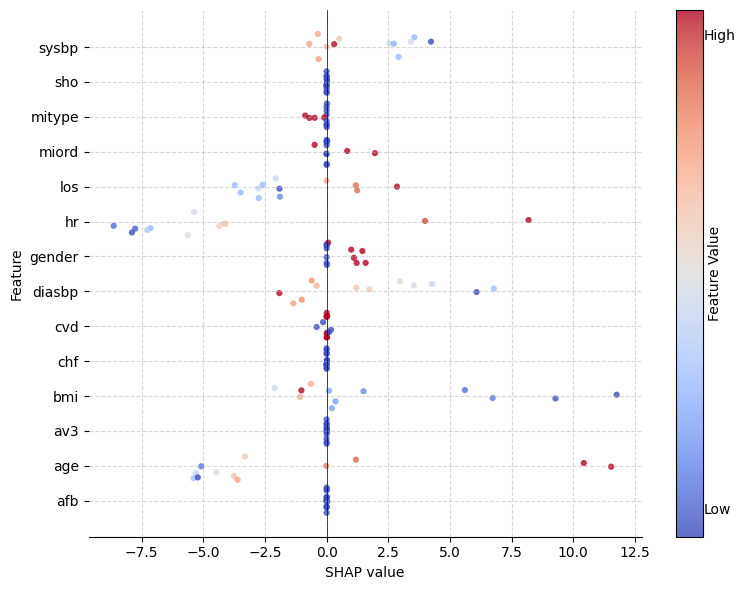

  0%|          | 0/15 [00:00<?, ?it/s]

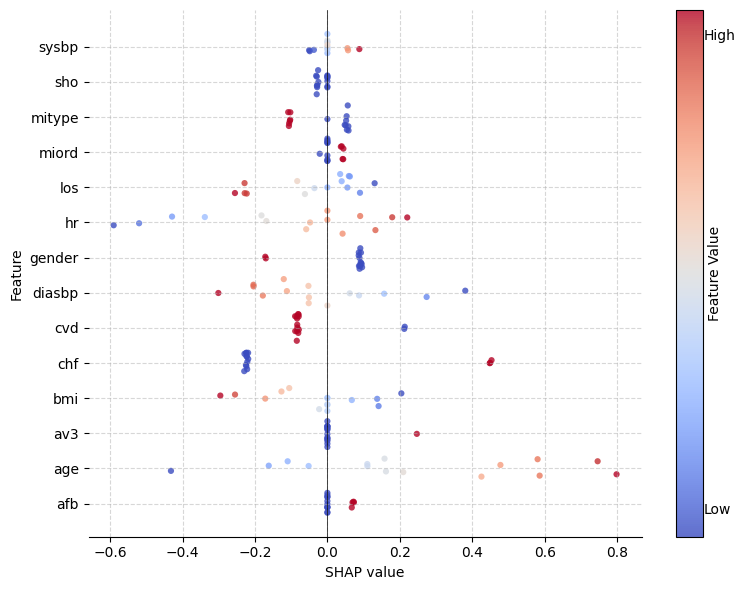

In [29]:
X, y = load_whas500()

cat_cols = ['afb', 'av3', 'chf', 'cvd', 'gender', 'miord', 'mitype', 'sho']
X[cat_cols] = OrdinalEncoder().fit_transform(X[cat_cols])

for model_name in ['rf', 'cox']:
  model, (X_train, y_train), (X_test, y_test) = split_and_train(X, y, model_name)
  eps = model.predict(X_train).std()/10.0
  ex_result, org_df = get_explanations(model, X_test, eps)
  make_plot(ex_result, org_df, f'whas_{model_name}', 'violin', 'SHAP value', (8, 6))